In [112]:
import pandas as pd

In [111]:
file_path = './data/raw_data/72物种+187种反应.xlsx'

# 提取所有物种的列表

In [113]:
# Read the Excel file, assuming that the species names are in the third column of the first sheet
df = pd.read_excel(file_path, sheet_name=0)

# Extract the species names from the third column, skipping the first row which contains the header
species_names = df.iloc[1:, 2].values  # .values returns a numpy array of the data
species_names_list = species_names.tolist()

# 提取所有reaction，并且清洗

In [114]:
# Define a function to extract reactants and products for all reactions
def extract_all_reactants_products(row):
    # Extract reactants, remove any leading/trailing whitespace, and ensure uniqueness
    reactants = list({str(reactant).strip() for reactant in row.loc['Reactants':'Unnamed: 6'].dropna()})
    # Extract products information and ignore coefficients, ensure uniqueness
    products_info = row.loc['Unnamed: 9':].dropna().tolist()
    # Take only the products (ignoring coefficients which are at odd indices, starting count from 0)
    products = list({str(product).strip() for product in products_info[::2]})
    return reactants, products

# Read the second sheet of the Excel file
df_second_sheet = pd.read_excel(file_path, sheet_name=1)

# Apply the function to each row in the dataframe and store in a new dataframe
all_reactions_info = df_second_sheet.iloc[1:].apply(extract_all_reactants_products, axis=1)
all_reactions_info = all_reactions_info.apply(pd.Series)
all_reactions_info.columns = ['Reactants', 'Products']

# Extract the reaction IDs
reaction_ids = df_second_sheet.iloc[1:]['反应编号'].values

# Create a dictionary with reaction IDs as keys and reactants/products as values
reactions_dict = {index: {'reactants': reactants, 'products': products, "reaction_id": reaction_id}
                  for index, (reaction_id, (reactants, products)) in enumerate(zip(reaction_ids, all_reactions_info.values))}

# Create lists for reactants and products
reactants_list = [info['reactants'] for info in reactions_dict.values()]
products_list = [info['products'] for info in reactions_dict.values()]



# Print the lists of reactants and products
print("Reactants List:")
print(reactants_list)
print("\nProducts List:")
print(products_list)


Reactants List:
[['NO2'], ['O2', 'O', 'M'], ['O3', 'NO'], ['O', 'NO2'], ['O', 'NO2'], ['NO', 'O'], ['O3', 'NO2'], ['O3'], ['O3'], ['M', 'O1D'], ['H2O', 'O1D'], ['O3', 'OH'], ['O3', 'HO2'], ['NO3'], ['NO3'], ['NO', 'NO3'], ['NO3', 'NO2'], ['NO3', 'NO2'], ['H2O', 'N2O5'], ['H2O', 'N2O5'], ['N2O5'], ['NO', 'O2'], ['NO', 'H2O', 'NO2'], ['NO', 'OH'], ['HONO'], ['OH', 'HONO'], ['HONO'], ['OH', 'NO2'], ['OH', 'HNO3'], ['NO', 'HO2'], ['NO2', 'HO2'], ['PNA'], ['OH', 'PNA'], ['HO2'], ['H2O', 'HO2'], ['H2O2'], ['OH', 'H2O2'], ['H2', 'O1D'], ['OH', 'H2'], ['OH', 'O'], ['OH'], ['OH'], ['OH', 'HO2'], ['O', 'HO2'], ['O', 'H2O2'], ['NO3', 'O'], ['NO3', 'OH'], ['NO3', 'HO2'], ['O3', 'NO3'], ['NO3'], ['PNA'], ['HNO3'], ['N2O5'], ['NO', 'XO2'], ['NO', 'XO2N'], ['HO2', 'XO2'], ['XO2N', 'HO2'], ['XO2'], ['XO2N'], ['XO2N', 'XO2'], ['OH', 'NTR'], ['NTR'], ['ROOH', 'OH'], ['ROOH'], ['OH', 'CO'], ['OH', 'CH4'], ['NO', 'MEO2'], ['HO2', 'MEO2'], ['MEO2'], ['OH', 'MEPX'], ['MEPX'], ['OH', 'MEOH'], ['FORM', 'OH'],

In [115]:
def clean_reactions(reactions, species_list):
    # Create a new dictionary to store cleaned reactions
    cleaned_reactions = {}
    
    for index, reaction_data in reactions.items():
        # Filter reactants and products that are in the species list
        valid_reactants = [r for r in reaction_data['reactants'] if r in species_list]
        valid_products = [p for p in reaction_data['products'] if p in species_list]
        reaction_id = reaction_data["reaction_id"]
        
        # Add the reaction to the cleaned reactions if it has at least one product
        if valid_products:
            cleaned_reactions[index] = {
                'reactants': valid_reactants,
                'products': valid_products,
                "reaction_id": reaction_id}
    
    return cleaned_reactions

# # Given `reactions_dict` and `species_names_list` from previous steps
# cleaned_reactions_dict = clean_reactions(reactions_dict, species_names_list)
# # Now `cleaned_reactions_dict` contains only reactions with valid reactants/products and at least one product
# # 打印清理后的反应数据
# print("清理后的反应数据：")
# for index, reaction_data in cleaned_reactions_dict.items():
#     print(f"反应编号: {reaction_data['reaction_id']}")
#     print(f"反应物: {reaction_data['reactants']}")
#     print(f"产物: {reaction_data['products']}")
#     print()  # 打印空行以便于分隔不同的反应
    
    
# 遍历每个反应，检查反应物和生成物的命名
for reaction_id, reaction_data in cleaned_reactions_dict.items():
    # 检查反应物中的命名
    for reactant in reaction_data['reactants']:
        if isinstance(reactant, int) or reactant.isdigit():
            print(f"Reaction ID: {reaction_id} contains a reactant with numeric name: {reactant}")
    
    # 检查生成物中的命名
    for product in reaction_data['products']:
        if isinstance(product, int) or product.isdigit():
            print(f"Reaction ID: {reaction_id} contains a product with numeric name: {product}")



# 保存物种列表和reaction的dict

In [116]:
# save the species list and cleaned reactions to a pickle file
import pickle
with open('./data/processed_data/species_list187.pkl', 'wb') as f:
    pickle.dump(species_names_list, f)
with open('./data/processed_data/cleaned_reactions187.pkl', 'wb') as f:
    pickle.dump(cleaned_reactions_dict, f)

# 可视化超图（以二部图的形式）

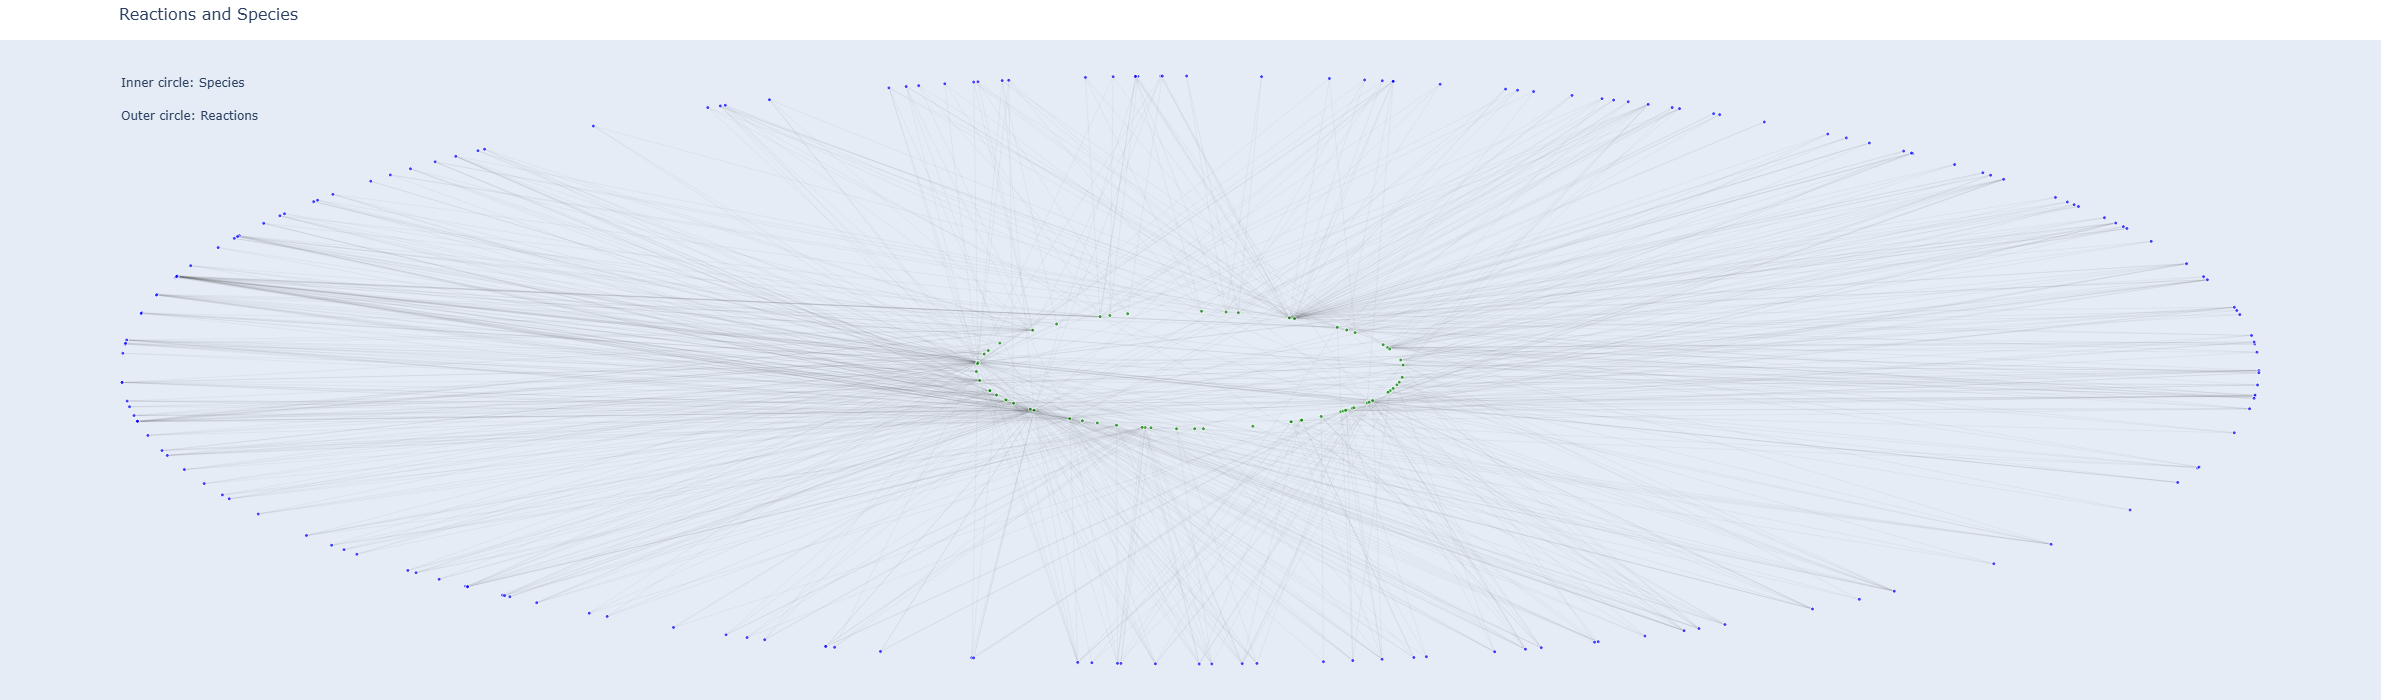

In [125]:
import plotly.graph_objects as go
import networkx as nx
import math

        
# 创建有向图
G = nx.DiGraph()

# for reaction_id, reaction_data in cleaned_reactions_dict.items():
#     G.add_node(reaction_id, bipartite=0, type='reaction')
#     for reactant in reaction_data['reactants']:
#         G.add_node(reactant, bipartite=1, type='reactant')
#         G.add_edge(reactant, reaction_id)
#     for product in reaction_data['products']:
#         G.add_node(product, bipartite=1, type='product')
#         G.add_edge(reaction_id, product)

for reaction_id, reaction_data in cleaned_reactions_dict.items():
    G.add_node(str(reaction_id), bipartite=0, type='reaction')  # 将 reaction_id 转换为字符串
    for reactant in reaction_data['reactants']:
        G.add_node(reactant, bipartite=1, type='reactant')
        G.add_edge(reactant, str(reaction_id))  # 确保边的连接也使用字符串类型的 reaction_id
    for product in reaction_data['products']:
        G.add_node(product, bipartite=1, type='product')
        G.add_edge(str(reaction_id), product)        
        
        
# 获取物种和反应节点的列表
species_nodes = [node for node, data in G.nodes(data=True) if data['type'] in ['reactant', 'product']]
reaction_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'reaction']

# 定义两个同心圆的半径
species_radius = 1
reaction_radius = 5

# initial_pos = nx.spring_layout(G, iterations=50)
initial_pos = nx.kamada_kawai_layout(G)

# 将每个节点的位置调整到同心圆上，保持角度不变
optimized_pos = {}
for node, (x, y) in initial_pos.items():
    angle = math.atan2(y, x)
    if G.nodes[node]['type'] == 'reaction':
        optimized_pos[node] = (reaction_radius * math.cos(angle), reaction_radius * math.sin(angle))
    else:
        optimized_pos[node] = (species_radius * math.cos(angle), species_radius * math.sin(angle))

pos = optimized_pos

# 设置图形的大小
fig_size = 700

# 创建边
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.1, color='rgba(50, 50, 50, 0.5)'),  # 设置边的颜色和透明度
    hoverinfo='none',
    mode='lines')

# 创建节点
node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[],
    marker=dict(
        size=[4 if data['type'] == 'reaction' else 4 for node, data in G.nodes(data=True)],  # 设置基于节点类型的大小
        color=[],
        line_width=1))

# 标记节点颜色和文本
colors = []
texts = []
for node, node_attrs in G.nodes(data=True):
    colors.append('blue' if node_attrs['type'] == 'reaction' else 'green')
    texts.append(node)

node_trace.marker.color = colors
# node_trace.text = texts

# 设置图表布局
layout = go.Layout(
    title='Reactions and Species',
    titlefont_size=16,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    width=fig_size,
    height=fig_size,
    annotations=[
        dict(# 标注内圈为物种
            text="Inner circle: Species",
            x=0.05, y=0.95, showarrow=False,
            xref="paper", yref="paper",
            align="left"),
        dict(# 标注外圈为反应
            text="Outer circle: Reactions",
            x=0.05, y=0.90, showarrow=False,
            xref="paper", yref="paper",
            align="left")]
)

# 创建图表
fig = go.Figure(data=[edge_trace, node_trace], layout=layout)

# 显示图表
fig.show()


Node: 0, Type: reaction
Node: NO2, Type: product
Node: NO, Type: product
Node: O, Type: reactant
Node: 1, Type: reaction
Node: O3, Type: product
Node: 2, Type: reaction
Node: 3, Type: reaction
Node: 4, Type: reaction
Node: NO3, Type: product
Node: 5, Type: reaction
Node: 6, Type: reaction
Node: 7, Type: reaction
Node: 8, Type: reaction
Node: O1D, Type: reactant
Node: 9, Type: reaction
Node: 10, Type: reaction
Node: OH, Type: product
Node: 11, Type: reaction
Node: HO2, Type: product
Node: 12, Type: reaction
Node: 13, Type: reaction
Node: 14, Type: reaction
Node: 15, Type: reaction
Node: 16, Type: reaction
Node: 17, Type: reaction
Node: N2O5, Type: reactant
Node: 18, Type: reaction
Node: HNO3, Type: product
Node: 19, Type: reaction
Node: 20, Type: reaction
Node: 21, Type: reaction
Node: 22, Type: reaction
Node: HONO, Type: reactant
Node: 23, Type: reaction
Node: 24, Type: reaction
Node: 25, Type: reaction
Node: 26, Type: reaction
Node: 27, Type: reaction
Node: 28, Type: reaction
Node: 29

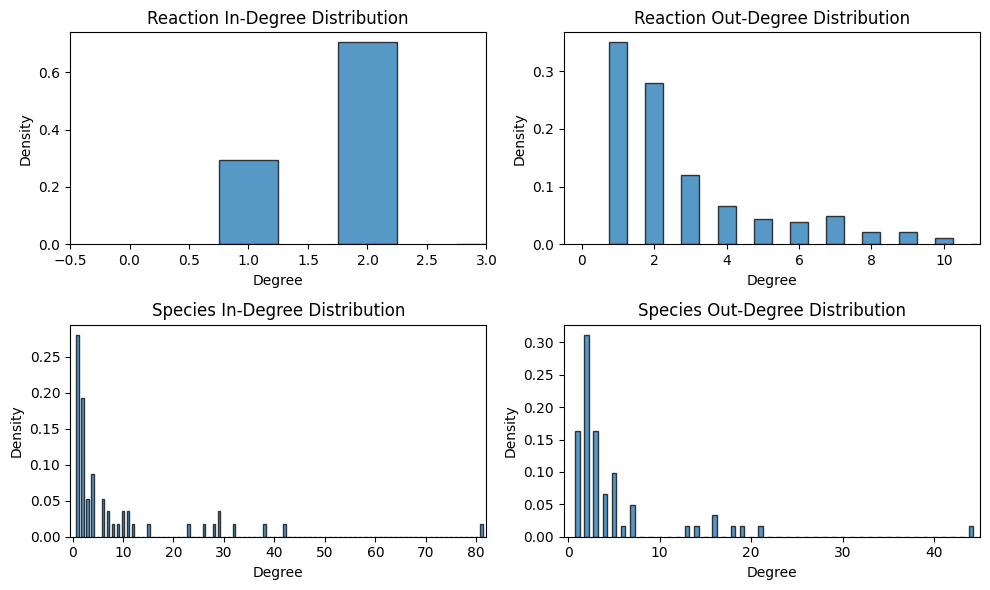

Reaction In-Degrees: [1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Reaction Out-Degrees: [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 4, 2, 2, 1, 1, 1, 1, 6, 6, 3, 4, 1, 1, 3, 1, 3, 3, 3, 2, 2, 2, 1, 3, 3, 1, 2, 3, 1, 1, 2, 1, 2, 3, 2, 1, 2, 2, 3, 4, 2, 1, 1, 2, 1, 2, 1, 2, 3, 4, 1, 2, 2, 2, 3, 4, 2, 3, 4, 7, 7, 1, 1, 9, 6, 8, 6, 5, 4, 5, 3, 6, 4, 7, 2, 5, 4, 2, 4, 2, 1, 1, 3, 5, 8, 7, 2, 3

In [126]:
import matplotlib.pyplot as plt

# 计算反应节点的入度和出度
reaction_in_degrees = [G.in_degree(node) for node, attr in G.nodes(data=True) if attr['type'] == 'reaction']
reaction_out_degrees = [G.out_degree(node) for node, attr in G.nodes(data=True) if attr['type'] == 'reaction']

# 计算物种节点的入度和出度
species_in_degrees = [G.in_degree(node) for node, attr in G.nodes(data=True) if attr['type'] in ['reactant', 'product']]
species_out_degrees = [G.out_degree(node) for node, attr in G.nodes(data=True) if attr['type'] in ['reactant', 'product']]



        
# 检查所有节点的类型
for node, attr in G.nodes(data=True):
    print(f"Node: {node}, Type: {attr['type']}")


#  # 检查是否存在没有分配类型的节点
# for node, attr in G.nodes(data=True):
#     if 'type' not in attr:
#         print(f"Warning: Node {node} does not have a type!")

# # 输出图的所有节点及其属性
# print("Nodes in the graph:")
# for node, attr in G.nodes(data=True):
#     print(f"Node: {node}, Attributes: {attr}")

# # 输出图的所有边
# print("\nEdges in the graph:")
# for edge in G.edges():
#     print(edge)

# # 输出入度和出度
# print("Reaction In-Degrees:", reaction_in_degrees)
# print("Reaction Out-Degrees:", reaction_out_degrees)
# print("Species In-Degrees:", species_in_degrees)
# print("Species Out-Degrees:", species_out_degrees)

    
# 绘制度分布曲线的函数
def plot_degree_distribution(ax, degrees, title, color, max_degree):
    # 设置以整数为中心的bins
    bins = [b + 0.5 for b in range(0, max_degree + 2)]
    ax.hist(degrees, bins=bins, density=True, alpha=0.75, edgecolor='black', rwidth=0.5)
    ax.set_title(title)
    ax.set_xlabel('Degree')
    ax.set_ylabel('Density')
    ax.set_xlim(left=-0.5, right=max_degree + 1)  # 设置x轴的范围

# 计算每个分布的最大度数
max_reaction_in_degree = max(reaction_in_degrees)
max_reaction_out_degree = max(reaction_out_degrees)
max_species_in_degree = max(species_in_degrees)
max_species_out_degree = max(species_out_degrees)

# 创建一个2x2的子图网格
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# 绘制四个度分布曲线，传递各自最大度数来设置x轴范围
plot_degree_distribution(axs[0, 0], reaction_in_degrees, 'Reaction In-Degree Distribution', 'blue', max_reaction_in_degree)
plot_degree_distribution(axs[0, 1], reaction_out_degrees, 'Reaction Out-Degree Distribution', 'red', max_reaction_out_degree)
plot_degree_distribution(axs[1, 0], species_in_degrees, 'Species In-Degree Distribution', 'green', max_species_in_degree)
plot_degree_distribution(axs[1, 1], species_out_degrees, 'Species Out-Degree Distribution', 'purple', max_species_out_degree)

# 调整布局以防止重叠
plt.tight_layout()

# 显示图形
plt.show()

print("Reaction In-Degrees:", reaction_in_degrees)
print("Reaction Out-Degrees:", reaction_out_degrees)
print("Species In-Degrees:", species_in_degrees)
print("Species Out-Degrees:", species_out_degrees)
for node, data in G.nodes(data=True):
    if data['type'] in ['reactant', 'product']:
        print(f"Node: {node}, Type: {data['type']}")


In [128]:
import networkx as nx
from collections import Counter

# 创建有向图
G = nx.DiGraph()

# 添加节点和边
for reaction_id, reaction_data in cleaned_reactions_dict.items():
    for reactant in reaction_data['reactants']:
        G.add_edge(reactant, reaction_id)
    for product in reaction_data['products']:
        G.add_edge(reaction_id, product)

# 计算每个物种的入度和出度
in_degrees = Counter({node: G.in_degree(node) for node in G if G.nodes[node].get('type') != 'reaction'})
out_degrees = Counter({node: G.out_degree(node) for node in G if G.nodes[node].get('type') != 'reaction'})

# 找到入度最大的10个物种
top_10_species_in_degree = in_degrees.most_common(20)

# 找到出度最大的10个物种
top_10_species_out_degree = out_degrees.most_common(20)

# 输出结果
print("Top 10 species by in-degree:")
for species, degree in top_10_species_in_degree:
    print(f"Species: {species}, In-Degree: {degree}")

print("\nTop 10 species by out-degree:")
for species, degree in top_10_species_out_degree:
    print(f"Species: {species}, Out-Degree: {degree}")
    

    
    
# print("Nodes and their types in the graph:")
# for node, data in G.nodes(data=True):
#     print(f"Node: {node}, Data: {data}")



Top 10 species by in-degree:
Species: HO2, In-Degree: 81
Species: XO2, In-Degree: 42
Species: NO2, In-Degree: 38
Species: FORM, In-Degree: 32
Species: ALDX, In-Degree: 29
Species: ALD2, In-Degree: 29
Species: OH, In-Degree: 28
Species: CO, In-Degree: 26
Species: PAR, In-Degree: 23
Species: C2O3, In-Degree: 15
Species: MEO2, In-Degree: 12
Species: XO2N, In-Degree: 11
Species: CXO3, In-Degree: 11
Species: HNO3, In-Degree: 10
Species: HCL, In-Degree: 10
Species: NO, In-Degree: 9
Species: NTR, In-Degree: 8
Species: NO3, In-Degree: 7
Species: CL, In-Degree: 7
Species: O, In-Degree: 6

Top 10 species by out-degree:
Species: OH, Out-Degree: 44
Species: NO3, Out-Degree: 21
Species: HO2, Out-Degree: 19
Species: NO, Out-Degree: 18
Species: O, Out-Degree: 16
Species: O3, Out-Degree: 16
Species: NO2, Out-Degree: 14
Species: CL, Out-Degree: 13
Species: 144, Out-Degree: 10
Species: 150, Out-Degree: 10
Species: 115, Out-Degree: 9
Species: 142, Out-Degree: 9
Species: 145, Out-Degree: 9
Species: 146, O